In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline


class ReLU(Baseline):
    LINK = "relu"

    def __init__(self, config: Config):
        super(ReLU, self).__init__(config=config)
        # self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[feature0, subject]
                    + jnp.where(
                        intensity <= a[feature0, subject],
                        0,
                        b[feature0, subject] * (intensity - a[feature0, subject])
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, subject] + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class SaturatedReLU(Baseline):
    LINK = "saturated_relu"

    def __init__(self, config: Config):
        super(SaturatedReLU, self).__init__(config=config)
        # self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[feature0, subject] - \
                    jnp.log(jnp.maximum(
                        1 / jnp.exp(v[feature0, subject]),
                        jnp.exp(-jax.nn.relu(
                            b[feature0, subject] * (intensity - a[feature0, subject])
                        ))
                    ))
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, subject] + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class Logistic4(Baseline):
    LINK = "logistic4"

    def __init__(self, config: Config):
        super(Logistic4, self).__init__(config=config)
        # self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[feature0, subject]
                    + (
                        H[feature0, subject]
                        / (
                            1 + jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject]))
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, subject] + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class Logistic5(Baseline):
    LINK = "logistic5"

    def __init__(self, config: Config):
        super(Logistic5, self).__init__(config=config)
        # self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[feature0, subject]
                    + (
                        H[feature0, subject]
                        / jnp.power(
                            1 + v[feature0, subject] * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                            1 / v[feature0, subject]
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, subject] + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class RectifiedLogistic(Baseline):
    LINK = "rectified_logistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        # self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=10))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=10 / 150))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", global_sigma_l * sigma_l_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", sigma_l * l_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[feature0, subject]
                    + jnp.where(
                        intensity <= a[feature0, subject],
                        0,
                        -l[feature0, subject]
                        + (
                            (H[feature0, subject] + l[feature0, subject])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[feature0, subject] + l[feature0, subject]) / l[feature0, subject],
                                            v[feature0, subject]
                                        )
                                    )
                                    * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject]))
                                ),
                                1 / v[feature0, subject]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, subject] + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


In [3]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison"

In [4]:
model_dir = "logistic5"
src = os.path.join(dir, model_dir, "numpyro_data.nc")

logistic5 = az.from_netcdf(src)


In [5]:
model_dir = "logistic4"
src = os.path.join(dir, model_dir, "numpyro_data.nc")

logistic4 = az.from_netcdf(src)


In [6]:
model_dir = "rectified_logistic"
src = os.path.join(dir, model_dir, "numpyro_data.nc")

rectified_logistic = az.from_netcdf(src)


In [7]:
model_dir = "saturated_relu"
src = os.path.join(dir, model_dir, "numpyro_data.nc")

saturated_relu = az.from_netcdf(src)

In [8]:
model_dir = "relu"
src = os.path.join(dir, model_dir, "numpyro_data.nc")

relu = az.from_netcdf(src)

In [9]:
fns = ["ReLU (High Bias, Low Variance)", "Saturated ReLU (High Bias, Low Variance)", "Logistic 4 (High Bias, Low Variance)", "Logistic 5 (Low Bias, High Variance)", "Rectified Logistic (Low Bias, Low Variance)"]
fns = ["ReLU", "Logistic 4", "Logistic 5", "Saturated ReLU", "Rectified Logistic"]

n_fns = len(fns)

colors = plt.cm.rainbow(np.linspace(0, 1, n_fns))

x = np.arange(0, 10, .1)
y = []

L, b, a = 1, 2, 4
relu_threshold = a
relu_fn = (
    L
    + jnp.where(
        x <= a,
        0,
        b * (x - a)
    )
)
y.append(relu_fn)


H, L, b, a = 10, 1, 2, 4
l4_inflection = a
l4_fn = (
    L
    + (
        H
        / (
            1 + np.exp(-b * (x - a))
        )
    )
)
y.append(l4_fn)

H, L, b, a, v = 10, 1, 2, 4, .01
l5_inflection = a
l5_fn = (
    L
    + (
        H
        / jnp.power(
            1 + v * jnp.exp(-b * (x - a)),
            1 / v
        )
    )
)
y.append(l5_fn)

L, b, a, g = 1, 2, 4, .001
satrel__threshold = a
satrel_fn = (
    L - \
    jnp.log(jnp.maximum(
        g,
        jnp.exp(-jax.nn.relu(b * (x - a)))
    ))
)
y.append(satrel_fn)


H, l, L, b, a, v = 10, 1, 1, 2, 4, .01
reclog_threshold = a
reclog_fn = (
    L
    + jnp.where(
        x <= a,
        0,
        -l
        + (
            (H + l)
            / jnp.power(
                1
                + (
                    (
                        -1
                        + jnp.power(
                            (H + l) / l,
                            v
                        )
                    )
                    * jnp.exp(-b * (x - a))
                ),
                1 / v
            )
        )
    )
)
y.append(reclog_fn)


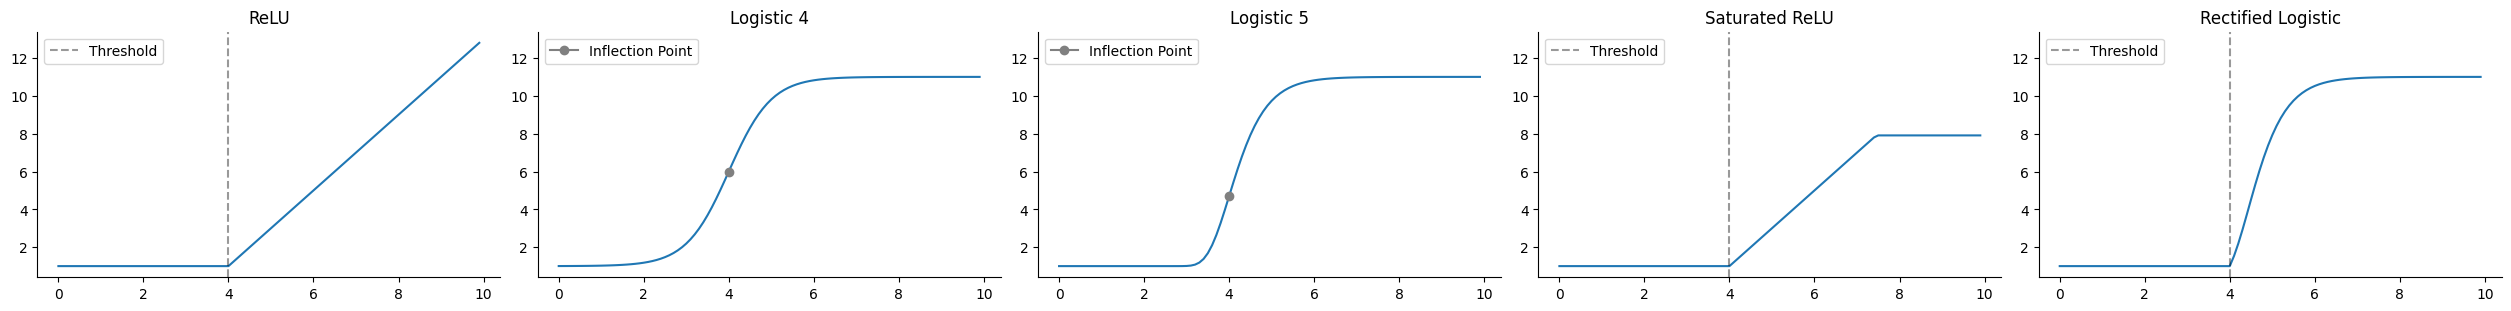

In [10]:
nrows, ncols = 1, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for _ in range(n_fns):
    row, col = i // ncols, i % ncols
    ax = axes[row, col]

    sns.lineplot(x=x, y=y[i], ax=ax)
    ax.set_title(fns[i])
    ax.tick_params(axis="both", labelleft=True, labelbottom=True, left=True, bottom=True)

    if i == 0:
        ax.axvline(x=relu_threshold, linestyle='--', color='black', alpha=.4, label="Threshold")

    if i == 3:
        ax.axvline(x=satrel__threshold, linestyle='--', color='black', alpha=.4, label="Threshold")

    if i == 1:
        ax.plot(x[x == l4_inflection], y[i][x == l4_inflection], marker="o", color='gray', label="Inflection Point")

    if i == 2:
        ax.plot(x[x == l5_inflection], y[i][x == l5_inflection], marker="o", color='gray', label="Inflection Point")

    if i == 4:
        ax.axvline(x=reclog_threshold, linestyle='--', color='black', alpha=.4, label="Threshold")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.legend(loc="upper left")
    i += 1


In [11]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/rats/J_RCML_000/link-comparison/rectified_logistic.toml"
config = Config(toml_path=toml_path)

r = ReLU(config=config)
sl = SaturatedReLU(config=config)
l4 = Logistic4(config=config)
l5 = Logistic5(config=config)
rl = RectifiedLogistic(config=config)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/data.csv"
df = pd.read_csv(src)

df, encoder_dict = r.load(df=df)




2023-10-27 03:40:03,345 - hbmep.config - INFO - Verifying configuration ...
2023-10-27 03:40:03,345 - hbmep.config - INFO - Success!
2023-10-27 03:40:03,354 - hbmep.model.baseline - INFO - Initialized model with relu link
2023-10-27 03:40:03,354 - hbmep.model.baseline - INFO - Initialized model with saturated_relu link
2023-10-27 03:40:03,355 - hbmep.model.baseline - INFO - Initialized model with logistic4 link
2023-10-27 03:40:03,355 - hbmep.model.baseline - INFO - Initialized model with logistic5 link
2023-10-27 03:40:03,356 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link
2023-10-27 03:40:03,407 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison/rectified_logistic
2023-10-27 03:40:03,408 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/link-comparison/rectified_logistic
2023-10-27 03:40:03,409 - hbmep.dataset.c

In [12]:
prediction_df = r.make_prediction_dataset(df=df, num_points=500)
# posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2023-10-27 03:40:03,464 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


In [13]:
def _get_posterior(numpyro_data):
    ps = {
        u: numpyro_data.posterior[u].to_numpy() for u in numpyro_data.posterior.data_vars
    }
    ps = {
        u: v.reshape(-1, *v.shape[2:]) for u, v in ps.items()
    }
    return ps


In [14]:
relu_ps = _get_posterior(relu)
saturated_relu_ps = _get_posterior(saturated_relu)
logistic4_ps = _get_posterior(logistic4)
logistic5_ps = _get_posterior(logistic5)
rectified_logistic_ps = _get_posterior(rectified_logistic)


In [15]:
relu_ppd = r.predict(df=prediction_df, posterior_samples=relu_ps)


2023-10-27 03:41:54,565 - hbmep.utils.utils - INFO - func:predict took: 1 min and 40.66 sec


In [16]:
saturated_relu_ppd = sl.predict(df=prediction_df, posterior_samples=saturated_relu_ps)


2023-10-27 03:43:36,609 - hbmep.utils.utils - INFO - func:predict took: 1 min and 41.96 sec


In [17]:
logistic4_ppd = l4.predict(df=prediction_df, posterior_samples=logistic4_ps)


2023-10-27 03:45:17,485 - hbmep.utils.utils - INFO - func:predict took: 1 min and 40.81 sec


In [18]:
logistic5_ppd = l5.predict(df=prediction_df, posterior_samples=logistic5_ps)


2023-10-27 03:47:00,189 - hbmep.utils.utils - INFO - func:predict took: 1 min and 42.64 sec


In [19]:
rectified_logistic_ppd = rl.predict(df=prediction_df, posterior_samples=rectified_logistic_ps)


2023-10-27 03:48:45,003 - hbmep.utils.utils - INFO - func:predict took: 1 min and 44.74 sec


In [20]:
c = (10, 4)

ind = df[r.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

ind = prediction_df[r.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_prediction_df = prediction_df[ind].reset_index(drop=True).copy()



In [21]:
posts = [relu_ppd, saturated_relu_ppd, logistic4_ppd, logistic5_ppd, rectified_logistic_ppd]


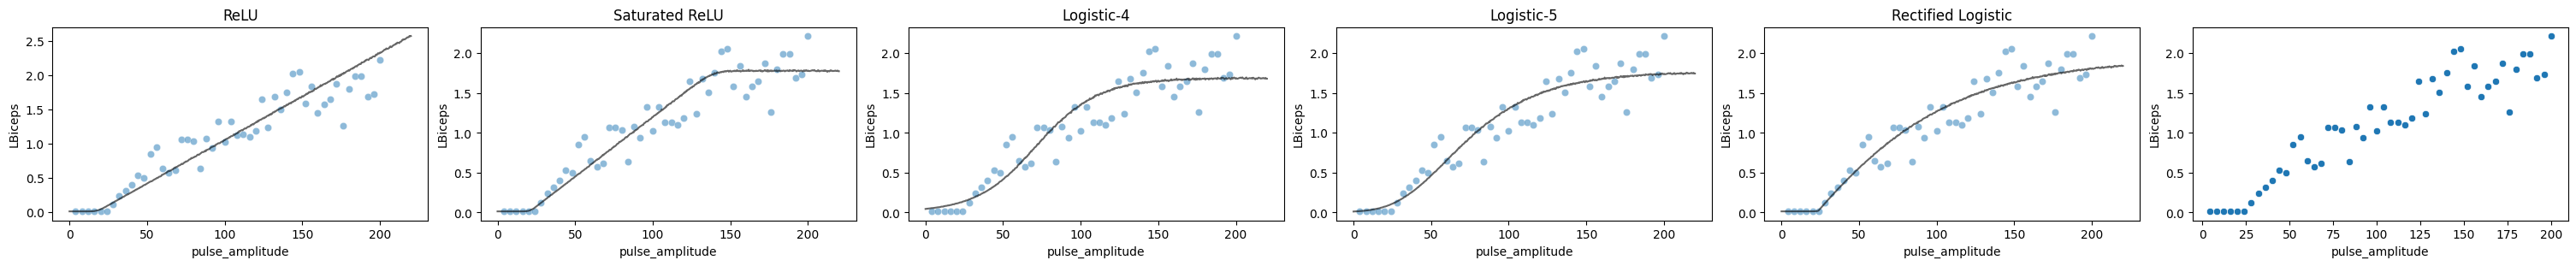

In [39]:
fns = ["ReLU", "Saturated ReLU", "Logistic-4", "Logistic-5", "Rectified Logistic"]
n_fns = len(fns)

nrows, ncols = 1, n_fns + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

i = 0
for _ in range(n_fns):
    curr_ppd = posts[i]
    ax = axes[i // ncols, i % ncols]
    sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax, alpha=.5)
    sns.lineplot(x=temp_prediction_df[r.intensity], y=np.array(curr_ppd[site.obs])[:, ind, 0].mean(axis=0), ax=ax, color="black", alpha=.6)
    ax.set_title(fns[i])
    i += 1

ax = axes[0, -1]
sns.scatterplot(x=temp_df[r.intensity], y=temp_df[r.response[0]], ax=ax)

fig.savefig("/home/vishu/comparison.png", dpi=600)


In [ ]:
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


: 

In [ ]:
c = (10, 4)


: 

: 

: 

In [ ]:
relu_ps = {
    u: relu.posterior[u].to_numpy() for u in relu.posterior.data_vars
}
rectified_logistic_ps = {
    u: v.reshape(-1, *v.shape[2:]) for u, v in rectified_logistic_ps.items()
}

rectified_logistic_ps = {
    u: rectified_logistic.posterior[u].to_numpy() for u in rectified_logistic.posterior.data_vars
}
rectified_logistic_ps = {
    u: v.reshape(-1, *v.shape[2:]) for u, v in rectified_logistic_ps.items()
}

: 

: 

In [ ]:
relu.posterior['a'].to_numpy()

array([[[[[117.68606231],
          [ 38.54833643],
          [ 15.42785027],
          ...,
          [ 75.26429841],
          [ 34.22916086],
          [ 65.28362974]],

         [[160.63081744],
          [201.44341278],
          [ 91.45934561],
          ...,
          [ 20.87977589],
          [ 30.93196448],
          [ 21.2249412 ]],

         [[116.59983213],
          [117.02348343],
          [ 89.05167169],
          ...,
          [ 66.60847223],
          [ 52.32027818],
          [ 24.71470663]],

         ...,

         [[208.77788919],
          [197.5075109 ],
          [202.90945607],
          ...,
          [ 93.59595734],
          [ 21.44002215],
          [ 42.25381993]],

         [[ 92.03356174],
          [218.24397168],
          [312.40652661],
          ...,
          [  1.14360651],
          [ 28.66616871],
          [ 33.56125154]],

         [[315.52095309],
          [222.06062715],
          [368.90833505],
          ...,
          [ 39.17311825],
 

: 

In [ ]:
relu_ps.keys()

dict_keys(['coords', 'attrs', 'dims', 'data_vars'])

: 

In [ ]:
relu_ps['dims']

{'chain': 4,
 'draw': 1000,
 'L_dim_0': 21,
 'L_dim_1': 8,
 'L_dim_2': 1,
 'L_raw_dim_0': 21,
 'L_raw_dim_1': 8,
 'L_raw_dim_2': 1,
 'a_dim_0': 21,
 'a_dim_1': 8,
 'a_dim_2': 1,
 'a_raw_dim_0': 21,
 'a_raw_dim_1': 8,
 'a_raw_dim_2': 1,
 'b_dim_0': 21,
 'b_dim_1': 8,
 'b_dim_2': 1,
 'b_raw_dim_0': 21,
 'b_raw_dim_1': 8,
 'b_raw_dim_2': 1,
 'g_1_dim_0': 21,
 'g_1_dim_1': 8,
 'g_1_dim_2': 1,
 'g_1_raw_dim_0': 21,
 'g_1_raw_dim_1': 8,
 'g_1_raw_dim_2': 1,
 'g_2_dim_0': 21,
 'g_2_dim_1': 8,
 'g_2_dim_2': 1,
 'g_2_raw_dim_0': 21,
 'g_2_raw_dim_1': 8,
 'g_2_raw_dim_2': 1,
 'global_sigma_L_dim_0': 1,
 'global_sigma_b_dim_0': 1,
 'global_sigma_g_1_dim_0': 1,
 'global_sigma_g_2_dim_0': 1,
 'global_sigma_p_dim_0': 1,
 'p_dim_0': 21,
 'p_dim_1': 8,
 'p_dim_2': 1,
 'p_raw_dim_0': 21,
 'p_raw_dim_1': 8,
 'p_raw_dim_2': 1,
 'sigma_L_raw_dim_0': 8,
 'sigma_L_raw_dim_1': 1,
 'sigma_b_raw_dim_0': 8,
 'sigma_b_raw_dim_1': 1,
 'sigma_g_1_dim_0': 8,
 'sigma_g_1_dim_1': 1,
 'sigma_g_1_raw_dim_0': 8,
 'sigma

: 

In [ ]:
relu_ps['data_vars']

KeyboardInterrupt: 

: 

In [ ]:
relu_ps.keys()

dict_keys(['coords', 'attrs', 'dims', 'data_vars'])

: 

In [ ]:
relu_obs[site.obs]

KeyError: 'obs'

: 

In [ ]:
relu_obs = relu.posterior

: 

In [ ]:
model_dict = {
    "Logistic-4": logistic4,
    "Logistic-5": logistic5,
    "Rectified Logistic": rectified_logistic,
    "ReLU": relu
}

compare_df = az.compare(model_dict)
compare_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/li

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified Logistic,0,6284.811345,1087.301148,0.000000,0.963614,170.556348,0.000000,True,log
Logistic-5,1,5580.637515,938.968214,704.173829,0.000000,163.737837,36.666371,True,log
Logistic-4,2,5207.907145,861.657734,1076.904200,0.019311,160.627743,47.943492,True,log
ReLU,3,4679.255011,912.022723,1605.556334,0.017075,173.059131,55.816338,True,log


: 

Text(0.5, 0, '$\\log($ELPD_LOO$)$')

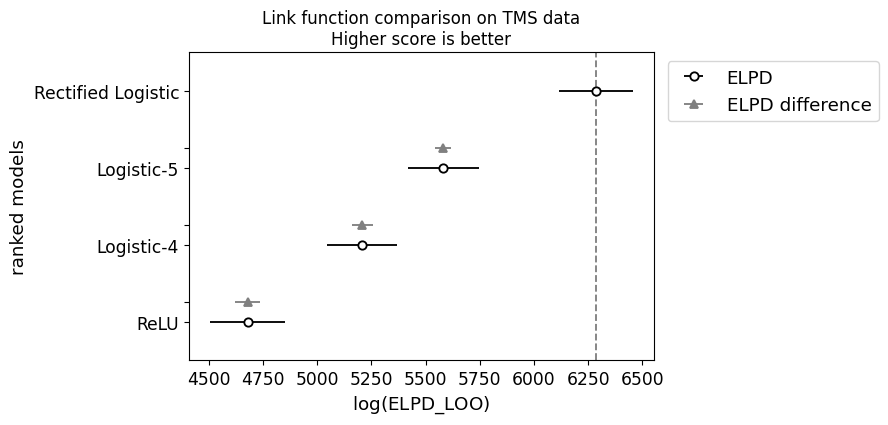

: 

In [ ]:
az.plot_compare(comp_df=compare_df)
plt.title("Link function comparison on TMS data\nHigher score is better")
plt.xlabel("$\log($ELPD_LOO$)$")


Text(0.5, 0.98, 'Leave one-out cross validation')

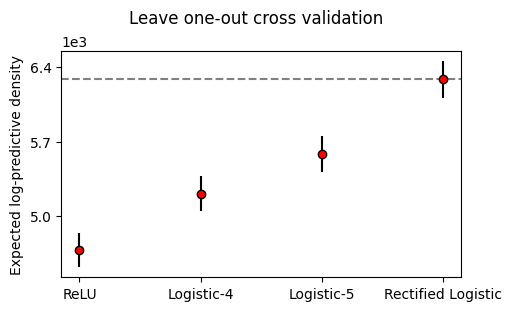

: 

In [ ]:
loo = compare_df.elpd_loo.to_dict()
se = compare_df.se.to_dict()

x, y = zip(*sorted(loo.items(), key=lambda item: item[1]))
xse, yse = zip(*sorted(se.items(), key=lambda item: item[1]))

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

ax = axes[0, 0]
# sns.scatterplot(x=x, y=y)
ax.errorbar(x=x, y=y, fmt="o", yerr=yse, ecolor="black", color="red", markeredgecolor="black")
ax.axhline(max(y), linestyle="dashed", color="grey")

ax.set_ylabel("Expected log-predictive density")
ax.set_yticks([5000, 5700, 6400])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
fig.suptitle("Leave one-out cross validation")
